# Building a Neural Network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import Data

In [2]:
mnist_test = pd.read_csv('MNIST_CSV/mnist_test.csv')
mnist_train = pd.read_csv('MNIST_CSV/mnist_train.csv')
mnist_test = np.array(mnist_test).T
mnist_train = np.array(mnist_train).T

## Test plot for a number

(-0.5, 27.5, 27.5, -0.5)

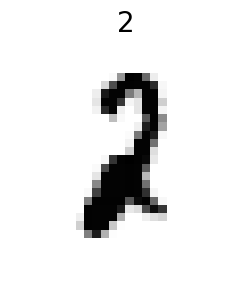

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
randint = np.random.randint(0, mnist_train.shape[1])
ax.imshow(np.reshape(mnist_train[1:, randint], (28, 28)), cmap='Greys')
ax.set_title(f"{mnist_train[0, randint]}", fontsize=20)
ax.axis('off') 

### Change single label into array of 0s and 1s, (one hot)

In [6]:
def one_hot(label):
    Y = np.zeros(10)
    Y[label] = 1
    return Y

## Coding one Neuron

In [7]:
class Neuron:
    def __init__(self, weight, biases, input):
        self.weight = weight
        self.biases = biases
        self.input = input
        self.output = 0 
    
    def forward(self) -> float:
        self.output = np.dot(self.input, self.weight) + self.biases
        return self.output

In [8]:
w = np.random.uniform(0, 5, 5)
b = np.random.uniform(0, 5, 5)
X_data = np.random.uniform(0, 100, 5)

neuron = Neuron(weight=w, biases=b, input=X_data)
output = neuron.forward()

print(output)

[127.90472536 124.49523772 128.71578304 126.68002781 129.14456505]


## Whole Network of hidden layers and neurons

In [27]:
def Linear(x, weights, bias):
    """Linear hidden layer"""
    return weights.dot(x) + bias

def ReLU(inputs) -> np.ndarray:
    """Activation function"""
    return np.maximum(0, inputs)

def softMax(inputs: np.ndarray) -> np.ndarray:
    exps = np.exp(inputs - inputs.max())
    return exps / np.sum(exps)

def initialise_weights(num_HL, HL_structure, num_inputs, num_outputs) -> (np.ndarray, np.ndarray):
    params = {"W0": np.random.normal(0, np.sqrt(2/num_inputs), size=(HL_structure[0], num_inputs))}
    for i in range(num_HL-1):
        params[f"W{i+1}"] = np.random.normal(0, np.sqrt(2/HL_structure[i]), size=(HL_structure[i+1], HL_structure[i]))
    params[f"W{num_HL}"] = np.random.normal(0, 2/HL_structure[-1], size=(num_outputs, HL_structure[-1]))
    biases = np.random.normal(size=num_HL+2)
    return params, biases

class NeuralNetwork:
    def __init__(self, num_inputs, hidden_layer_structure, num_outputs, lr=0.1):
        self.num_inputs = num_inputs
        self.num_hidden_layers = len(hidden_layer_structure)
        self.hidden_layer_structure = hidden_layer_structure
        self.num_outputs = num_outputs
        self.lr = lr
        
        # Randomly initialise weights and biases
        self.weights, self.biases = initialise_weights(num_HL=self.num_hidden_layers,
                                              HL_structure=self.hidden_layer_structure,
                                              num_inputs=self.num_inputs,
                                              num_outputs=self.num_outputs)
        
        # Information I may want
        self.num_nodes = self.num_hidden_layers + sum(hidden_layer_structure)

    def forward(self, As):
        Zs_dict = {}
        As_dict = {}
        length_weights = len(self.weights)
        for i in range(length_weights-1):
            Zs = Linear(As, self.weights[f"W{i}"], self.biases[i])
            As = ReLU(Zs)

            Zs_dict[f"Z{i}"] = Zs
            As_dict[f"A{i}"] = As

        Zs = Linear(As, self.weights[f"W{length_weights-1}"], self.biases[length_weights-1])
        Zs_dict[f"Z{length_weights-1}"] = Zs
        As_dict[f"A{length_weights-1}"] = Zs

        return Zs_dict, As_dict
    
    def update_weights(self, grad_w, grad_b):
        for i in range(len(self.weights)):
            self.weights[f"W{i}"] -= self.lr * grad_w[f"GW{i}"]
            self.biases[i] -= self.lr * grad_b[f"GB{i}"]

In [28]:
def cross_entropy(outputs, targets):
    """Classification Loss Function"""
    normalised_outputs = softMax(outputs)
    return - np.sum(targets * np.log(normalised_outputs))

def deriv_ReLU(x):
    ret = np.zeros_like(x)
    ret[x >= 0] = 1
    return ret

In [90]:
class Criterion:
    def __init__(self, NN):
        self.NN = NN
        self.params = self.NN.weights
        self.biases = self.NN.biases
        self.num_layers = len(self.params.keys())

    def backward(self, Zs, As, true_label, OG_array):
        m = 0.2
        grad_weights = {}
        grad_biases = {}

        # Initial layer
        true_one_hot = one_hot(true_label)
        dZ = (softMax(list(As.values())[-1]) - true_one_hot)[:, None]
        dW = (1/m)*(dZ.dot(list(As.values())[-2][:, None].T))
        dB = (1/m)*(np.sum(dZ))

        grad_weights[f"GW{self.num_layers-1}"] = dW
        grad_biases[f"GB{self.num_layers-1}"] = dB

        # Hidden layers
        i = len(self.params.values())-2
        for weights in list(self.params.values())[::-1][:-1]:
            if i == 0:
                A = OG_array
            else:
                A = As[f"A{i-1}"]
            Z = Zs[f"Z{i}"]
            dZ = weights.T.dot(dZ) 
            dZ = dZ * deriv_ReLU(Z[:, None])

            dW = (1/m) * (dZ.dot(A[:, None].T))
            dB = (1/m) * (np.sum(dZ))

            grad_weights[f"GW{i}"] = dW
            grad_biases[f"GB{i}"] = dB
            i -= 1

        return grad_weights, grad_biases

In [83]:
randint = np.random.randint(0, mnist_train.shape[1])
rand_img = mnist_train[1:, randint]
true_label = mnist_train[0, randint]

NN = NeuralNetwork(num_inputs=rand_img.shape[0], hidden_layer_structure=[50, 25, 15], num_outputs=10)
c = Criterion(NN=NN)
Zs, As = NN.forward(rand_img)
grad_w, grad_b = c.backward(Zs=Zs, As=As, true_label=true_label, OG_array=rand_img)
NN.update_weights(grad_w=grad_w, grad_b=grad_b)

In [124]:
HLS = [15, 10]
NN = NeuralNetwork(num_inputs=784, hidden_layer_structure=HLS, num_outputs=10, lr=0.0001)
loss = Criterion(NN=NN)

error_list = []

num_epochs = 50
for epoch in range(num_epochs):
    for i, img in enumerate(mnist_train.T):
        label = img[0]
        data = img[1:]/255
        Zs, As = NN.forward(data)
        grad_w, grad_b = loss.backward(Zs=Zs, As=As, true_label=label, OG_array=data)
        NN.update_weights(grad_w=grad_w, grad_b=grad_b)
        if i % 1000 == 0:
            error = cross_entropy(outputs=list(As.values())[-1], targets=one_hot(label=label))
            print(f"Training... | Error: {error} | Epoch {epoch + 1}/{num_epochs} | Image {i} / {mnist_train.shape[1]}", end="\r")
            error_list.append(error)

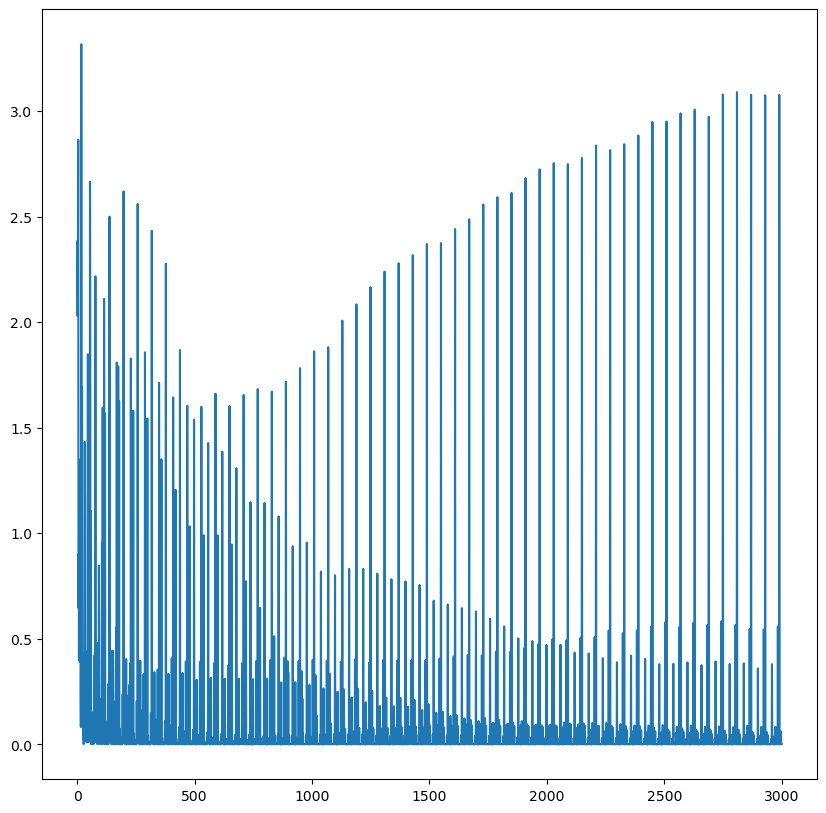

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(error_list)

In [126]:
guesses = np.zeros((2, mnist_test.shape[1]))
correct = 0

for i, img in enumerate(mnist_test.T):
    label = img[0]
    data = img[1:]/255
    Zs, As = NN.forward(data)
    guess = softMax(list(As.values())[-1])

    guesses[0, i] = label
    guesses[1, i] = list(guess).index(max(guess))

    if label == list(guess).index(max(guess)):
        correct += 1

print(f"Accuracy: {(correct / mnist_test.shape[1])*100:.2f}%")

Accuracy: 95.26%


(-0.5, 27.5, 27.5, -0.5)

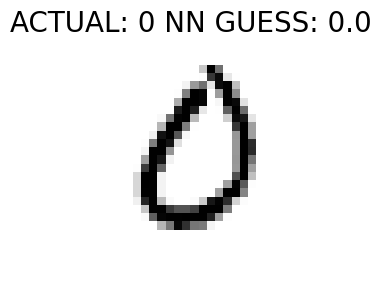

In [128]:
fig, ax = plt.subplots(figsize=(3, 3))
randint = np.random.randint(0, mnist_test.shape[1])
ax.imshow(np.reshape(mnist_test[1:, randint], (28, 28)), cmap='Greys')
ax.set_title(f"ACTUAL: {mnist_test[0, randint]} NN GUESS: {guesses[1, randint]}", fontsize=20)
ax.axis('off') 